<a href="https://colab.research.google.com/github/sener7106/TiL/blob/main/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 신용카드 사용 내역을 통한 연체자 예측

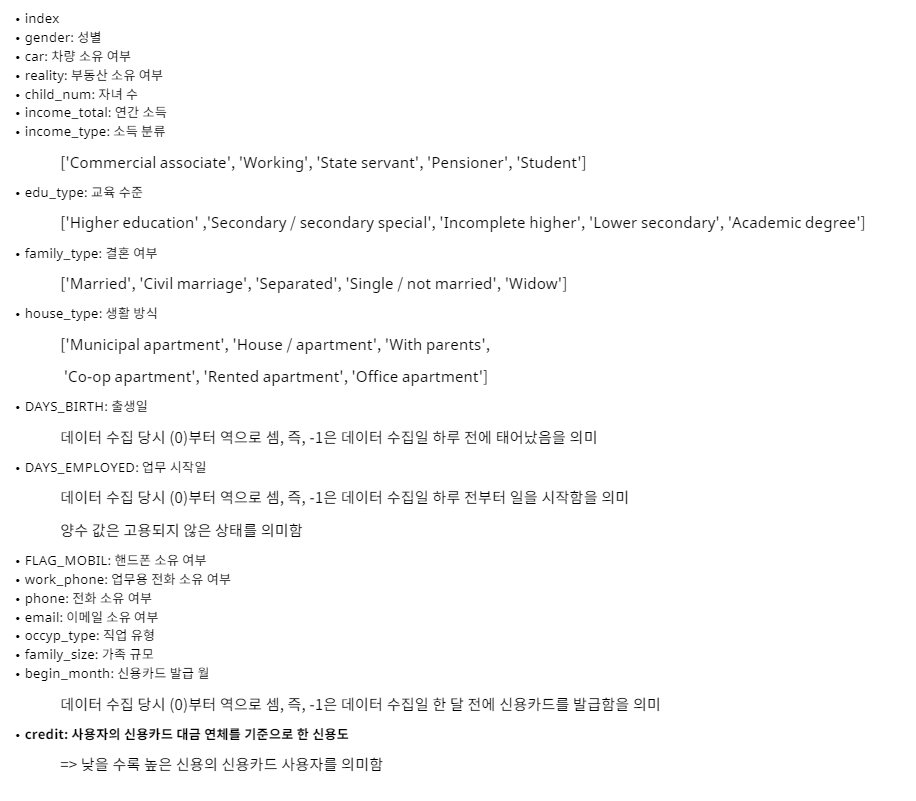

# 데이터 칼럼의 분석
- 결측치를 어떻게 처리할 것인가 ?
- income_total 에 따라서 신용등급은 영향을 받을 것인가?
- child_num과 family_type에 따라서 신용등급은 영향이 있을 것인가?
- house_type 에 따라서 신용등급은 영향을 받을 것인가?
- 업무 시작일, 나이에 따라서 신용등급은 영향을 받을 것인가?

In [ ]:
!pip install catboost
!pip install category_encoders

     |████████████████████████████████| 76.1 MB 1.3 MB/s 
     |████████████████████████████████| 82 kB 361 kB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import warnings, random
warnings.filterwarnings(action = 'ignore')

%matplotlib inline
plt.style.use('ggplot')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

ModuleNotFoundError: ignored

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
csv_path = '/content/drive/MyDrive/ML_MacineLearning/credit'

In [6]:
df_train = pd.read_csv(f'{csv_path}/train.csv')
df_test = pd.read_csv(f'{csv_path}/test.csv')

In [ ]:
df_train.fillna('NaN', inplace = True)
df_test.fillna('NaN', inplace = True)

## 이상치처리

In [ ]:
df_train = df_train[(df_train['family_size'] <= 7)]
df_train = df_train.reset_index(drop = True)

In [ ]:
df_train.shape

(26451, 20)

In [8]:
df_train['begin_month'].value_counts()

-7.0     662
-11.0    617
-8.0     612
-3.0     593
-6.0     591
        ... 
-58.0    244
-59.0    242
-60.0    235
 0.0     231
-57.0    228
Name: begin_month, Length: 61, dtype: int64

## 특성 확인


#### index, FLAG_MOBIL 삭제

In [ ]:
df_train.drop(['index', 'FLAG_MOBIL'], axis =1, inplace = True)
df_test.drop(['index', 'FLAG_MOBIL'], axis =1, inplace = True)

In [ ]:
df_train.head(5)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,Managers,2.0,-26.0,2.0


trainWithoutOutliers = train[(train['count']>= q1 - (1.5 * IQR)) & (train['count']<=(q3 * 1.5 *IQR))]

#### DAYS_EMPLOYEED : 양수인 데이터는 무직자로 판단, 0 처리

In [ ]:
df_train['DAYS_EMPLOYEED'] = df_train['DAYS_EMPLOYED'].map(lambda x : 0 if x > 0 else x)

In [ ]:
df_train['family_size'].sort_values(ascending = False)

10319    7.0
17975    7.0
9613     7.0
22589    7.0
19789    7.0
        ... 
15642    1.0
21156    1.0
9708     1.0
21152    1.0
19426    1.0
Name: family_size, Length: 26451, dtype: float64

In [ ]:
df_train['child_num'].sort_values(ascending = False)

12873    5
22589    5
10319    5
9613     5
20114    5
        ..
16004    0
16005    0
16006    0
16007    0
0        0
Name: child_num, Length: 26451, dtype: int64

In [ ]:
df_train[df_train['child_num'] > df_train['family_size']]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
14900,M,Y,N,2,225000.0,Working,Secondary / secondary special,Married,House / apartment,-14776,-2212,1,0,0,0,Drivers,1.0,-30.0,2.0


In [ ]:
def remove_outlier(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    # print(q1, q3, lower_bound, upper_bound)
    
    mask = np.where((data<=upper_bound) & (data>=lower_bound), data, np.NaN)
    return mask

In [ ]:
df_train.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

## 데이터 컬럼 확인하기

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9e6e56b50>,
      dtype=object)

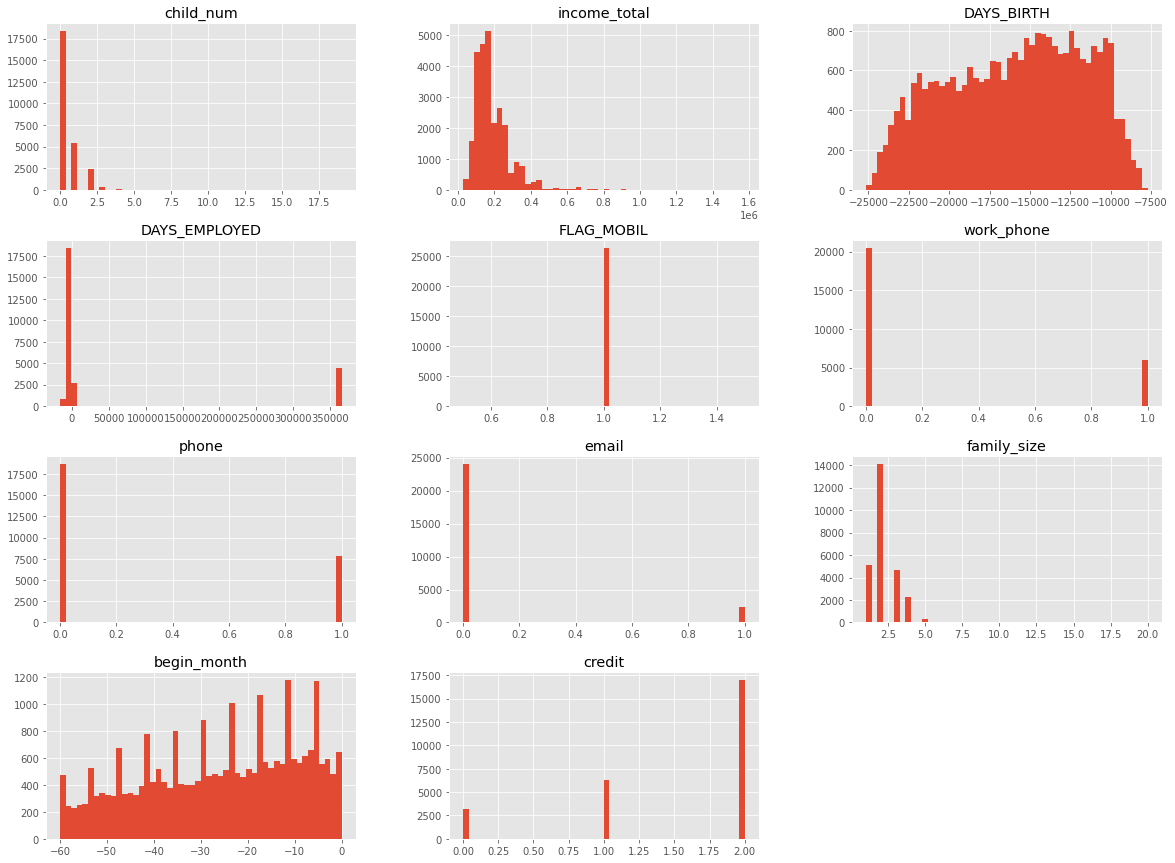

In [ ]:
df_train.hist(bins= 50, figsize = (20, 15))

In [ ]:
# FLAG_MOBIL 은 모든 데이터가 1.0 이므로 종속변수에 영향을 미치지 않을 것이라 생각하고 삭제
# begin_month, DAYS_BIRTH의 경우, 음수치를 가지므로 적절한 컬럼으로 변경
# DAYS_EMPLOYED, 고용일의 경우 3500000을 초과하는 데이터가 존재하는데, 이에대한 확인이 필요함.

In [ ]:
df_train.head(5)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


NameError: ignored

In [ ]:
corr_matrix = df_train.corr()

In [ ]:
corr_matrix['credit'].sort_values(ascending  = False)

credit           1.000000
email            0.014812
income_total     0.008555
family_size      0.008227
child_num        0.004081
phone            0.003452
work_phone      -0.003134
DAYS_EMPLOYED   -0.003798
DAYS_BIRTH      -0.025187
begin_month     -0.147477
FLAG_MOBIL            NaN
Name: credit, dtype: float64

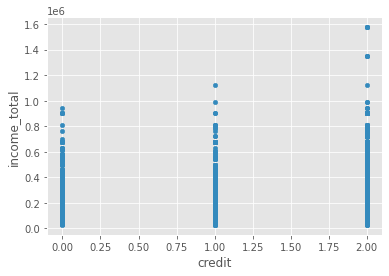

In [ ]:
from pandas.plotting import scatter_matrix

df_train.plot(kind = 'scatter', x = 'credit', y = 'income_total')

(array([  84.,  341., 2788., 7265., 7716., 5505., 2362.,  308.,   77.,
          11.]),
 array([10.20362918, 10.61024291, 11.01685664, 11.42347037, 11.83008409,
        12.23669782, 12.64331155, 13.04992528, 13.45653901, 13.86315274,
        14.26976647]),
 <a list of 10 Patch objects>)

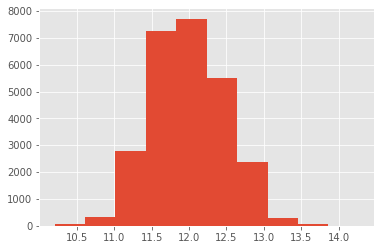

In [ ]:
plt.hist(np.log1p(df_train['income_total']))

In [ ]:
df_train['DAYS_EMPLOYED'].describe()

count     26457.000000
mean      59068.750728
std      137475.427503
min      -15713.000000
25%       -3153.000000
50%       -1539.000000
75%        -407.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [ ]:
df_train.head(5

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
df_train['credit'].value_counts()

2.0    16968
1.0     6267
0.0     3222
Name: credit, dtype: int64

In [ ]:
df_train['gender'] = np.where(df_train['gender'] == 'F', 0, 1)
df_train['car'] = np.where(df_train['car'] == 'N', 0, 1)
df_train['reality'] = np.where(df_train['reality'] == 'N', 0, 1)

In [ ]:
df_train['family_type'].unique()

array(['Married', 'Civil marriage', 'Separated', 'Single / not married',
       'Widow'], dtype=object)

In [ ]:
df_train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,0,0,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,0,0,1,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,1,1,1,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,0,0,1,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,0,1,1,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [ ]:
df_train['occyp_type'].value_counts()

Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

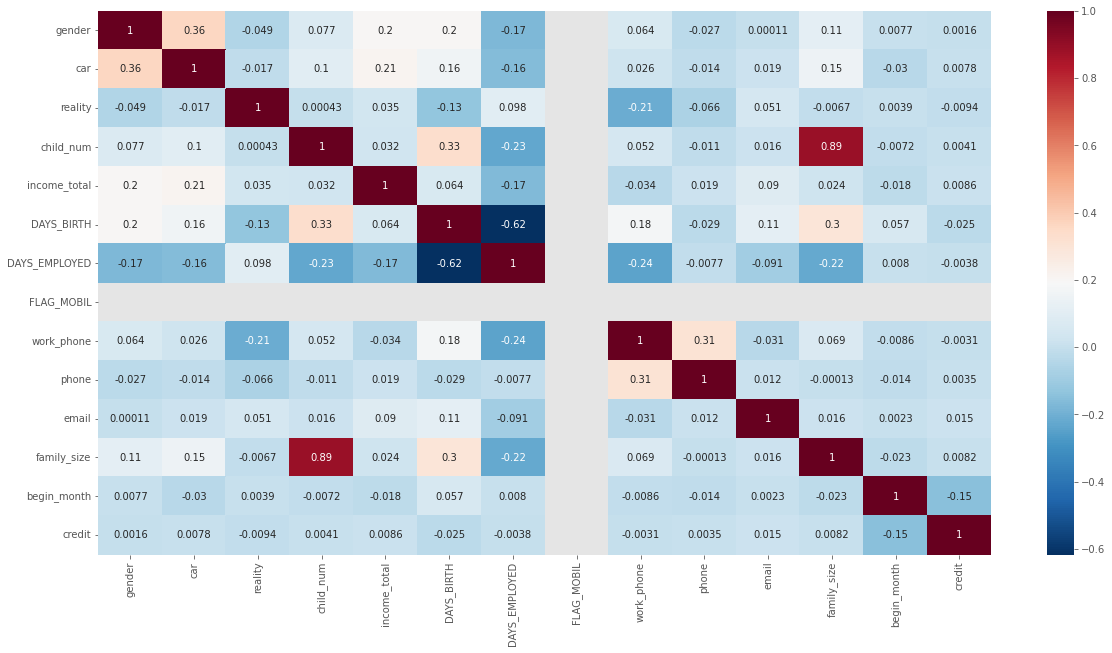

In [ ]:
# train 데이터의 상관계수를 히트맵으로 출력
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(df_train.corr(), annot = True, cmap = 'RdBu_r')

In [ ]:
df_train.skew()

gender           0.717818
car              0.495580
reality         -0.742076
child_num        2.852376
income_total     2.659271
DAYS_BIRTH      -0.185986
DAYS_EMPLOYED    1.777596
FLAG_MOBIL       0.000000
work_phone       1.318953
phone            0.903042
email            2.838422
family_size      1.431759
begin_month     -0.290050
credit          -1.124384
dtype: float64

(array([22019.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4438.]),
 array([-15713. ,  22382.6,  60478.2,  98573.8, 136669.4, 174765. ,
        212860.6, 250956.2, 289051.8, 327147.4, 365243. ]),
 <a list of 10 Patch objects>)

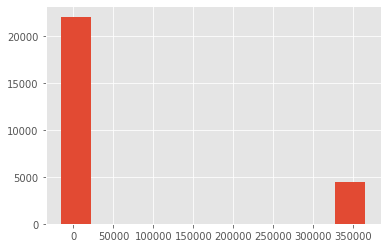

In [ ]:
plt.hist((df_train['DAYS_EMPLOYED']))

In [ ]:
df_train['Age'] = ((- df_train['DAYS_BIRTH']) / 365).round(0)

In [ ]:
df_train['Employeed'] = ((- df_train['DAYS_EMPLOYED']) / 365).round(0)

(array([ 703., 3344., 3641., 3921., 2924., 3148., 2888., 2807., 2366.,
         715.]),
 array([21. , 25.8, 30.6, 35.4, 40.2, 45. , 49.8, 54.6, 59.4, 64.2, 69. ]),
 <a list of 10 Patch objects>)

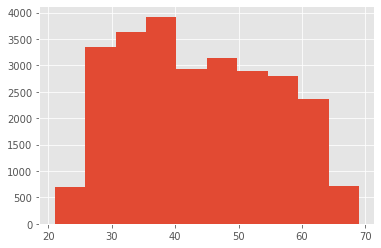

In [ ]:
plt.hist(df_train['Age'])

In [ ]:
df_train.corr()['credit']

gender           0.001562
car              0.007761
reality         -0.009387
child_num        0.004081
income_total     0.008555
DAYS_BIRTH      -0.025187
DAYS_EMPLOYED   -0.003798
FLAG_MOBIL            NaN
work_phone      -0.003134
phone            0.003452
email            0.014812
family_size      0.008227
begin_month     -0.147477
credit           1.000000
Age              0.025109
Employeed        0.003783
Name: credit, dtype: float64